In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Arc
import matplotlib.patches as mpatches
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

sys.path.append("../../unfolding/")

from Application_functions import *
from functions_folding import *
from Unfolding import Unfolding

NA = np.newaxis

In [2]:
def load_h5(filename):
    hf = h5py.File(filename, 'r')
    d_CC = np.array(hf.get("radii"))
    E_init = np.array(hf.get("E_init"))
    E_final = np.array(hf.get("E_final"))
    functional = np.array(hf.get("functional"))
    basis_set = np.array(hf.get("basis_set"))
    geometries = np.array(hf.get("geometries"))
    hf.close()
    return d_CC, E_init, E_final, geometries

In [3]:
### Load the data for the hinge_0 closing path with F as halogen ###
d_CC_F, E_init_F, E_final_F, geometries_F = load_h5("../../data/C60_closing/hinge_0_F.h5")
d_CC_F_inside, E_init_F_inside, E_final_F_inside, geometries_F_inside = load_h5("../../data/C60_closing//hinge_0_F_inside.h5")

d_CC_F = np.concatenate([d_CC_F[:8],d_CC_F[9:]],axis=0)
E_init_F = np.concatenate([E_init_F[:8],E_init_F[9:]],axis=0)
E_final_F = np.concatenate([E_final_F[:8],E_final_F[9:]],axis=0)
geometries_F = np.concatenate([geometries_F[:8],geometries_F[9:]],axis=0)

d_CC_Cl, E_init_Cl, E_final_Cl, geometries_Cl = load_h5("../../data/C60_closing/hinge_0_Cl.h5")
dual_unfolding, graph_unfolding, graph_unfolding_faces, vertices_final, bonds_toBe, lengths_toBe, angles_f, opt_geom, halogen_positions, neighbours, graph_faces = read_unfolding("../../data/unfolding_graph/C60data.h5")

In [4]:
C60 = Unfolding(dual_unfolding, graph_unfolding_faces, graph_faces, graph_unfolding, neighbours, halogen_positions=halogen_positions, root_node=0, bonds_toBe=bonds_toBe, angles_f=angles_f)

In [5]:
### Make the unfolding look a little nicer ### 
### Quick'n dirty optimise ###
for _ in range(10000):
    C60.optimise_geometry(delta=1e-16)

In [6]:
def distances(geometries, graph):
    dist = np.zeros([geometries.shape[0],graph.shape[0],graph.shape[1]])
    for i in range(geometries.shape[0]):
        geometry = geometries[i][-1]
        d = np.linalg.norm(geometry[:60,NA,:] - geometry[C60.graph_unfolding_array],axis=-1)
        dist[i] = d
    return dist

In [7]:
def dist_pair(pair, dist, graph):
    id_y = np.where(graph[pair[0]] == pair[1])[0]
    if len(id_y) < 1:
        print("Vertex %i is not a neighbour of vertex %i" %(pair[1],pair[0]))
    return dist[:,pair[0],id_y].flatten()

In [8]:
def chain_dist(chain, dist, graph):
    dist_chain = np.zeros([len(chain)-1,dist.shape[0]])
    for i in range(len(chain)-1):
        pair = [chain[i], chain[i+1]]
        tmp = dist_pair(pair, dist, graph)
        dist_chain[i] = tmp
    return dist_chain

In [9]:
def distance_bond(bond_type, geo):
    dist = np.linalg.norm(geo[:,-1][:,bond_type[:,0]] - geo[:,-1][:,bond_type[:,1]],axis=-1)
    return dist

In [10]:
def get_angle_plot(a, b, c, offset = 0.3, color = "k", origin = [0,0], len_x_axis = 1, len_y_axis = 1, lw=1.):
    a, b, c = a[:-1], b[:-1], c[:-1]

    left = b - a
    left = left / np.linalg.norm(left)
    
    right = c - a
    right = right / np.linalg.norm(right)
    
    angles = np.rad2deg([np.arctan2(right[1],right[0]),np.arctan2(left[1],left[0])])
    theta = np.rad2deg(np.arccos(left@right))
    
    return mpatches.Arc(a, np.linalg.norm(a-b)*offset, np.linalg.norm(a-b)*offset, 0, angles[0], angles[0] + theta, color=color,lw=lw )

In [11]:
def plot_angle(a,b,c,ax,lw=1.):
    angle_plot  =  get_angle_plot(a,b,c,lw=lw)
    ax.add_patch(angle_plot)
    return ax

In [12]:
dists_F = distances(geometries_F, C60.graph_unfolding_array)
dists_F_inside = distances(geometries_F_inside, C60.graph_unfolding_array)
dists_Cl = distances(geometries_Cl, C60.graph_unfolding_array)

In [13]:
chain = [0,6,15,16,36,37,38,48,49,50,51,39,17,18,19,20,21,8,1,2,9,22,23,40,41,42,52,53,54,55,43,24,25,26,27,28,11,3,4,12,29,30,44,45,46,56,57,58,59,47,31,32,33,34,35,14,5,0]
hex_pent = np.array([[1,0],[2,3],[4,5],[6,7],[7,8],[9,10],[10,11],[12,13],[13,14]])
hex_hex = np.array([[7,18],[16,17],[38,39],[10,25],[23,24],[42,43],[13,32],[30,31],[46,47]])

periphery_dist_F = chain_dist(chain, dists_F, C60.graph_unfolding_array)
periphery_dist_F_inside  = chain_dist(chain, dists_F_inside , C60.graph_unfolding_array)
periphery_dist_Cl = chain_dist(chain, dists_Cl, C60.graph_unfolding_array)

dist_HH_F = distance_bond(hex_hex, geometries_F).T
dist_HP_F = distance_bond(hex_pent, geometries_F).T

dist_HH_F_inside  = distance_bond(hex_hex, geometries_F_inside ).T
dist_HP_F_inside  = distance_bond(hex_pent, geometries_F_inside ).T

dist_HH_Cl = distance_bond(hex_hex, geometries_Cl).T
dist_HP_Cl = distance_bond(hex_pent, geometries_Cl).T

pent_periphery = np.array([0,17,19,36,38,55])
hex_periphery = np.setdiff1d(np.arange(len(periphery_dist_F)),pent_periphery)

dist_H_periphery_F = periphery_dist_F[hex_periphery].T
dist_P_periphery_F = periphery_dist_F[pent_periphery].T

dist_H_periphery_F_inside  = periphery_dist_F_inside[hex_periphery].T
dist_P_periphery_F_inside  = periphery_dist_F_inside[pent_periphery].T

dist_H_periphery_Cl = periphery_dist_Cl[hex_periphery].T
dist_P_periphery_Cl = periphery_dist_Cl[pent_periphery].T

In [14]:
periphery_dist_F_filtered = np.hstack([periphery_dist_F[:,:8],periphery_dist_F[:,9:]])
d_CC_F_filtered = np.hstack([d_CC_F[:8],d_CC_F[9:]])

def fit_clusters(data_per, data_hex, data_pent, n, point, lw=4.5,graph=C60):
    ### Fit a k-means cluster to the data
    X = np.vstack([data_per, data_hex, data_pent])
    X = X[:,point].reshape(-1,1)
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    centers = kmeans.cluster_centers_

    phi = np.linspace(0, 2*np.pi, len(centers) +1)
    rgb_cycle = np.vstack((            # Three sinusoids
        .5*(1.+np.cos(phi          )), # scaled to [0,1]
        .5*(1.+np.cos(phi+2*np.pi/3)), # 120° phase shifted.
        .5*(1.+np.cos(phi-2*np.pi/3)))).T # Shape = (60,3)
    
    fig, ax = plt.subplots(figsize=(15,5))
    geometry = graph.vertex_coords
    for i in range(data_per.shape[0]):
        pair = [chain[i], chain[i+1]]
        tmp = np.stack([geometry[pair[0],:-1],geometry[pair[1],:-1]]).T
        color_id = kmeans.predict(data_per[i,point].reshape(-1,1))[0]
        ax.plot(tmp[0],tmp[1],'b-',lw=lw, color=rgb_cycle[color_id])
    
    hex_pent = np.array([[1,0],[2,3],[4,5],[6,7],[7,8],[9,10],[10,11],[12,13],[13,14]])
    hex_hex = np.array([[7,18],[16,17],[38,39],[10,25],[23,24],[42,43],[13,32],[30,31],[46,47]])

    
    for i in range(data_hex.shape[0]):
        pair = hex_hex[i]
        tmp = np.stack([geometry[pair[0],:-1],geometry[pair[1],:-1]]).T
        color_id = kmeans.predict(data_hex[i,point].reshape(-1,1))[0]
        ax.plot(tmp[0],tmp[1],'b-',lw=lw, color=rgb_cycle[color_id])
        
    for i in range(data_pent.shape[0]):
        pair = hex_pent[i]
        tmp = np.stack([geometry[pair[0],:-1],geometry[pair[1],:-1]]).T
        color_id = kmeans.predict(data_pent[i,point].reshape(-1,1))[0]
        ax.plot(tmp[0],tmp[1],'b-',lw=lw, color=rgb_cycle[color_id])
        
    ax.axis('equal');
    return kmeans, fig, ax, rgb_cycle

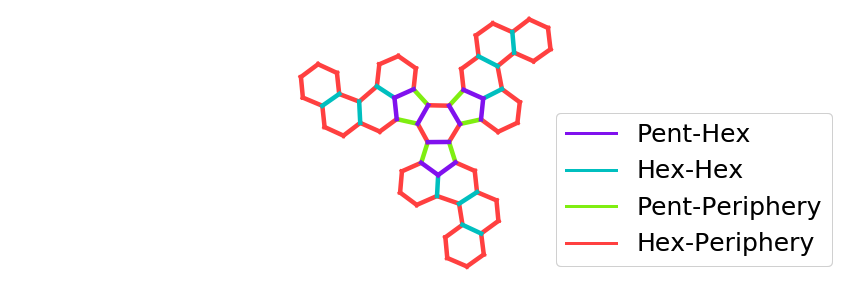

In [15]:
data_per = periphery_dist_F
data_hex = dist_HH_F
data_pent = dist_HP_F
fake_data = periphery_dist_F.copy()
fake_data[pent_periphery] *= -10
kmeans, fig, ax, color = fit_clusters(fake_data, dist_HH_F*100,dist_HP_F*1000, 4, point=-1)
ax.axis('off');
legend_elements = [plt.Line2D([0], [0], color=color[1], lw=3, label='Pent-Hex'),
                   plt.Line2D([0], [0], color=color[2], lw=3, label='Hex-Hex'),
                   plt.Line2D([0], [0], color=color[3], lw=3, label='Pent-Periphery'),
                   plt.Line2D([0], [0], color=color[0], lw=3, label='Hex-Periphery')]

legend = ax.legend(handles=legend_elements,fontsize=25, loc='lower right')
ax.add_artist(legend)
#fig.savefig("../../Illustrations/bond_types.pdf", bbox_inches = 'tight', pad_inches = 0.3)

In [16]:
def bond_lengths(d_CC, dist_HH, dist_HP, dist_H_periphery, dist_P_periphery, title):
    fig, ax = plt.subplots(2,2,figsize=(25,15),sharey=True, sharex=True)
    ax[0,0].plot(d_CC, dist_HP.T, marker='x', linestyle='dashed', color=color[1]);
    ax[0,1].plot(d_CC, dist_HH.T, marker='x', linestyle='dashed',color=color[2]);
    ax[1,0].plot(d_CC, dist_H_periphery, marker='x', linestyle='dashed',color=color[0]);
    ax[1,1].plot(d_CC, dist_P_periphery, marker='x', linestyle='dashed',color=color[3]);

    legend_elements = [plt.Line2D([0], [0], color=color[1], lw=3, marker='x', label='Pent-Hex', linestyle='dashed'),
                       plt.Line2D([0], [0], color=color[2], lw=3, marker='x',label='Hex-Hex', linestyle='dashed'),
                       plt.Line2D([0], [0], color=color[3], lw=3, marker='x',label='Pent-Periphery', linestyle='dashed'),
                       plt.Line2D([0], [0], color=color[0], lw=3, marker='x',label='Hex-Periphery', linestyle='dashed')]

    legend = fig.legend(handles=legend_elements,fontsize=25, loc='center')
    fig.add_artist(legend)


    fig.text(0.05, 0.5, 'Bond distances [$\AA$]',fontweight='bold',  ha='center', va='center', rotation='vertical', fontsize=30)
    fig.text(0.5, 0.04, '$d_{CC}$ [$\AA$]', fontweight='bold',ha='center', va='center', fontsize=37);
    ax[0,0].tick_params(labelsize=30)
    ax[1,0].tick_params(labelsize=30)
    ax[1,1].tick_params(labelsize=30)

    #fig.savefig(title)

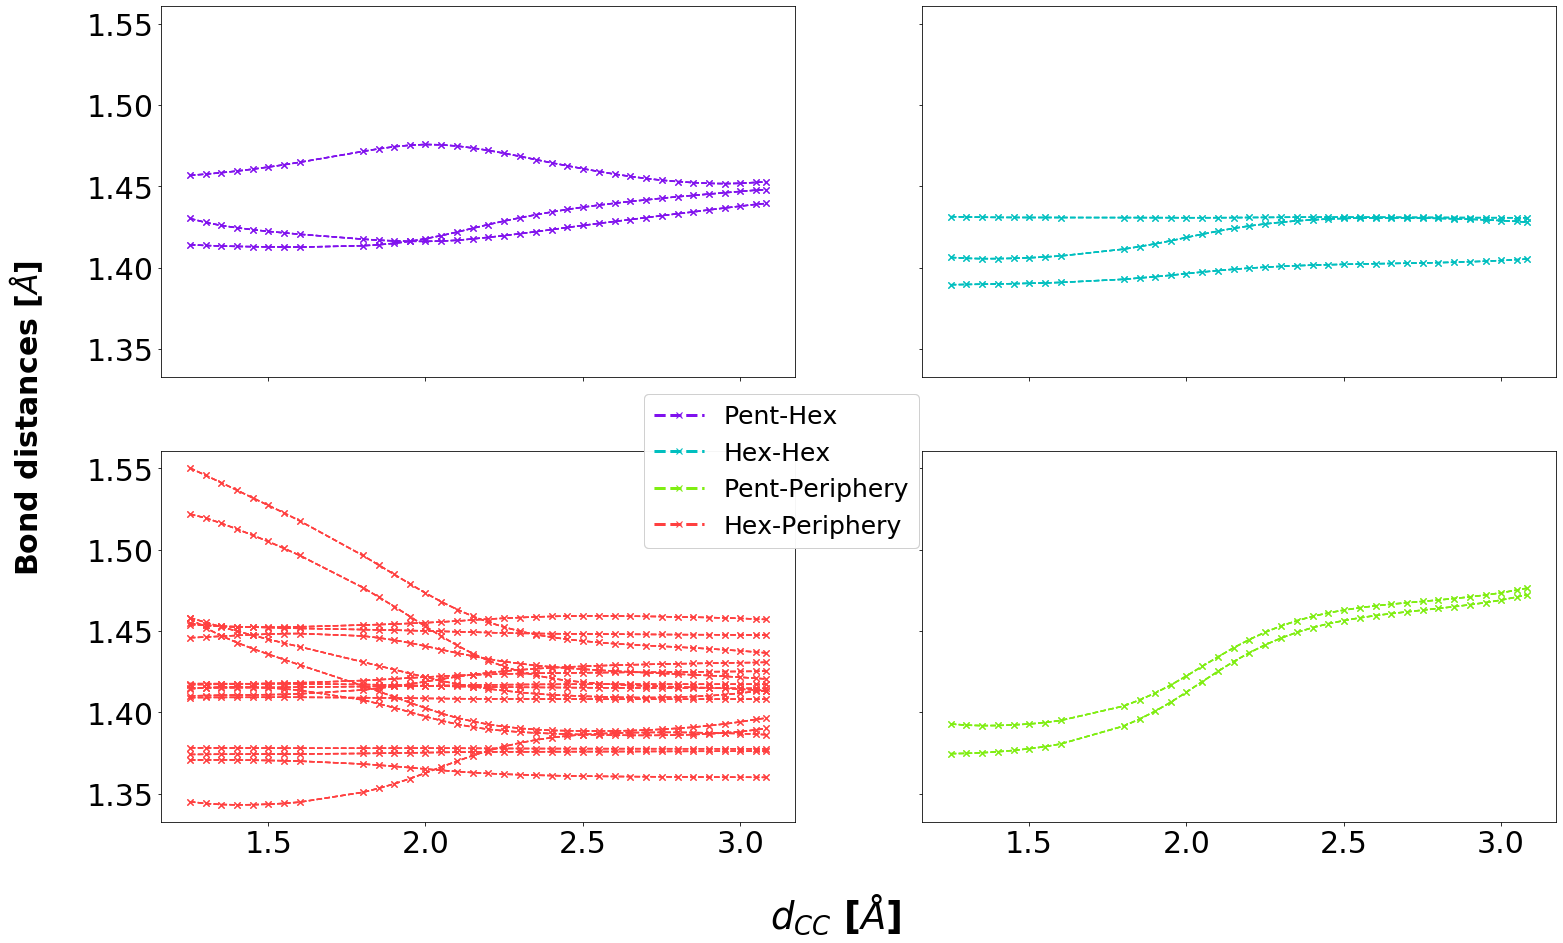

In [17]:
bond_lengths(d_CC_F, dist_HH_F, dist_HP_F, dist_H_periphery_F, dist_P_periphery_F, title='../../Illustrations/bond_lenghts.pdf')

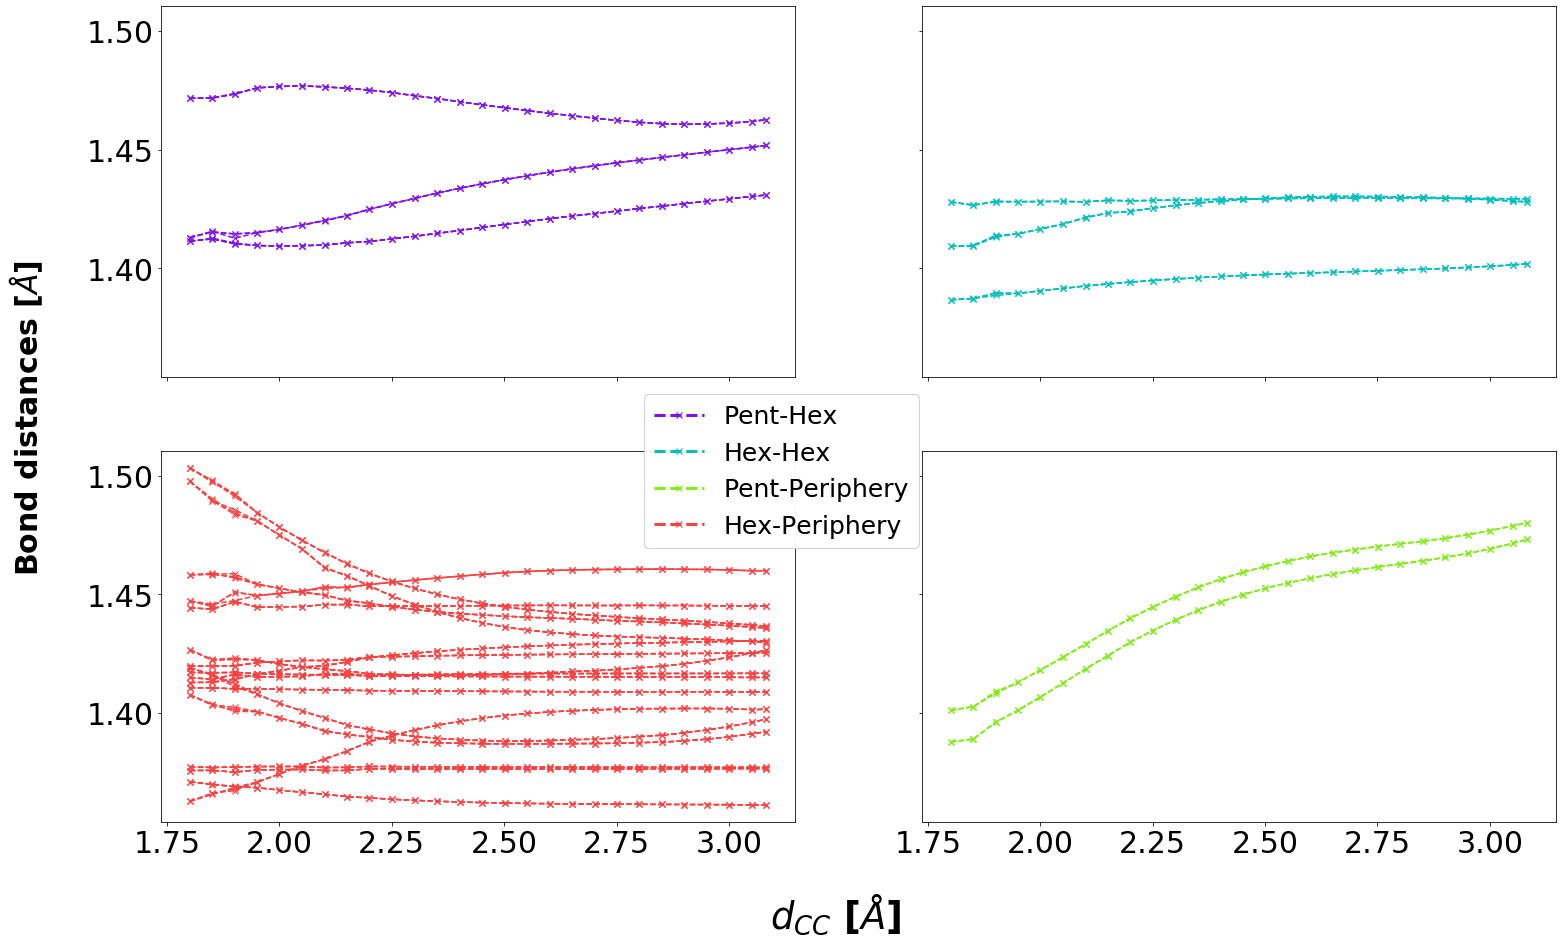

In [18]:
bond_lengths(d_CC_Cl, dist_HH_Cl, dist_HP_Cl, dist_H_periphery_Cl, dist_P_periphery_Cl, title='../../Illustrations/bond_lenghts_Cl.pdf')

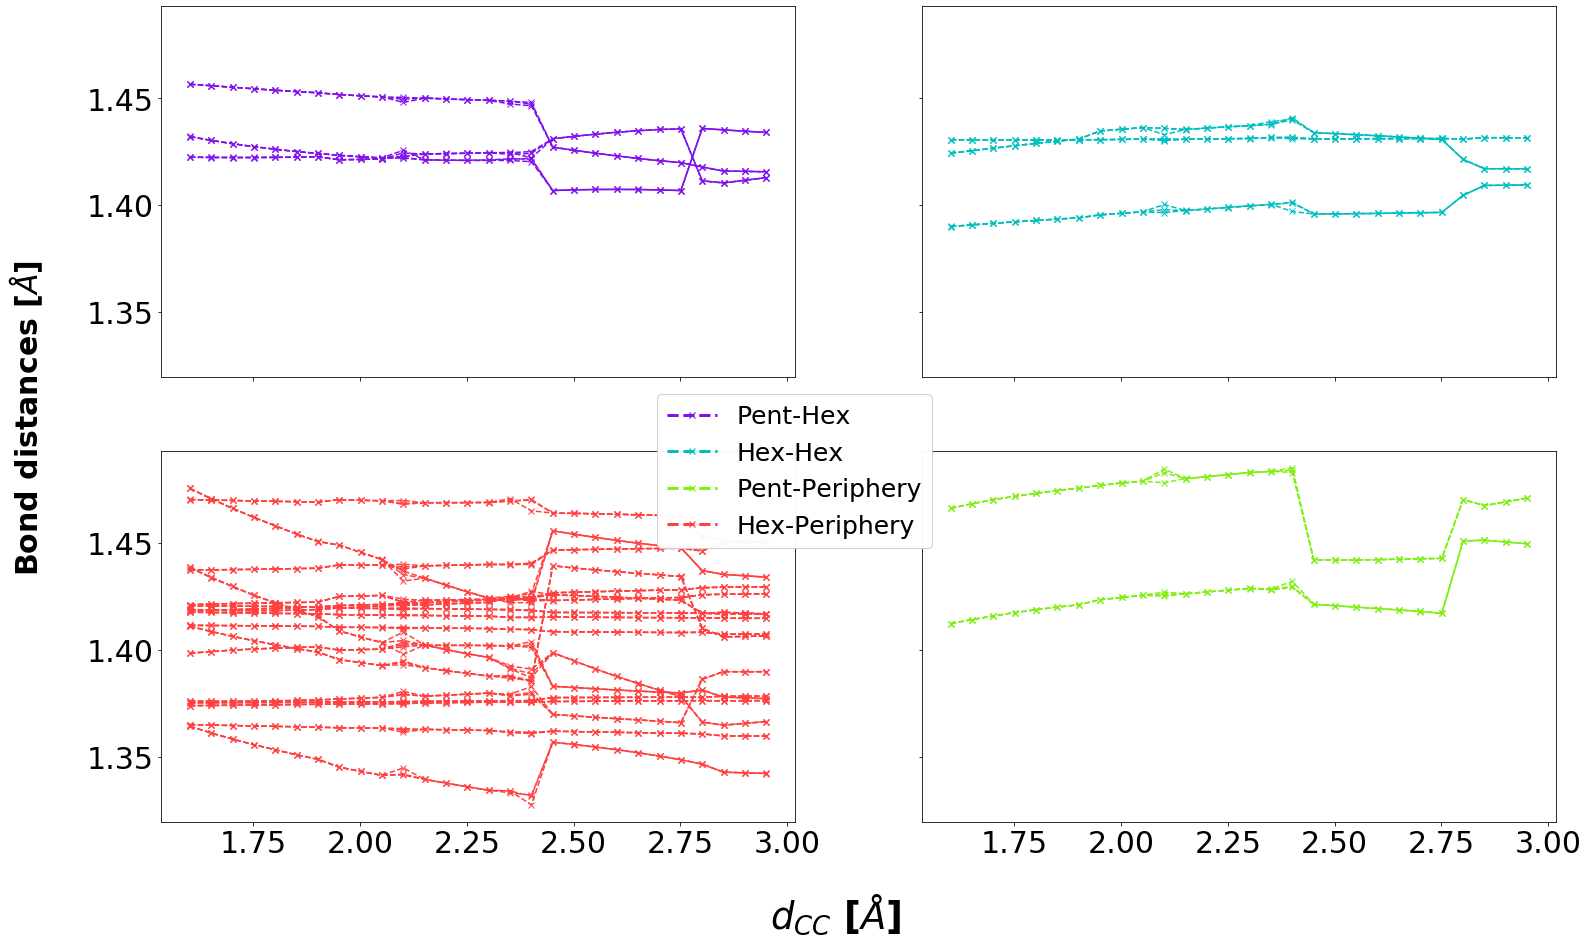

In [19]:
bond_lengths(d_CC_F_inside, dist_HH_F_inside, dist_HP_F_inside, dist_H_periphery_F_inside, dist_P_periphery_F_inside, title='../../Illustrations/bond_lenghts_F_inside.pdf')

In [20]:
def bond_variety(dist_H_periphery, hex_periphery, graph, title):
    fig, ax = plt.subplots(figsize=(10,10))
    variety = np.argsort(np.abs(np.max(dist_H_periphery,axis=0) - np.min(dist_H_periphery,axis=0)))
    val = np.abs(np.max(dist_H_periphery,axis=0) - np.min(dist_H_periphery,axis=0))
    geometry = graph.vertex_coords

    c = np.arange(1, dist_H_periphery.shape[1] + 1)
    norm = mpl.colors.Normalize(vmin=val.min(), vmax=val.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)                    
    cmap.set_array([])

    for i in range(len(hex_periphery)):
        id_i = hex_periphery[i]
        pair = [chain[id_i], chain[id_i+1]]
        tmp = np.stack([geometry[pair[0],:-1],geometry[pair[1],:-1]]).T
        color = cmap.to_rgba(val[i])
        ax.plot(tmp[0],tmp[1],'b-',lw=4.5, color=color)

    ax.axis('off');
    ax.axis('equal');

    cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
    cbar = fig.colorbar(cmap, ticks=[val.max(), val.min()], cax = cbaxes)
    cbar.ax.set_yticklabels(["%.3f [$\AA$]" %val.max(), "%.3f [$\AA$]" % val.min()],fontsize=30)  # vertically oriented colorbar

    legend_elements = [plt.Line2D([0], [0], color=cmap.to_rgba(val[variety[-10]]), lw=5, label='Amplitude in bond length')]
    legend = ax.legend(handles=legend_elements,fontsize=30, loc='lower left')
    ax.add_artist(legend)

    #fig.savefig(title)

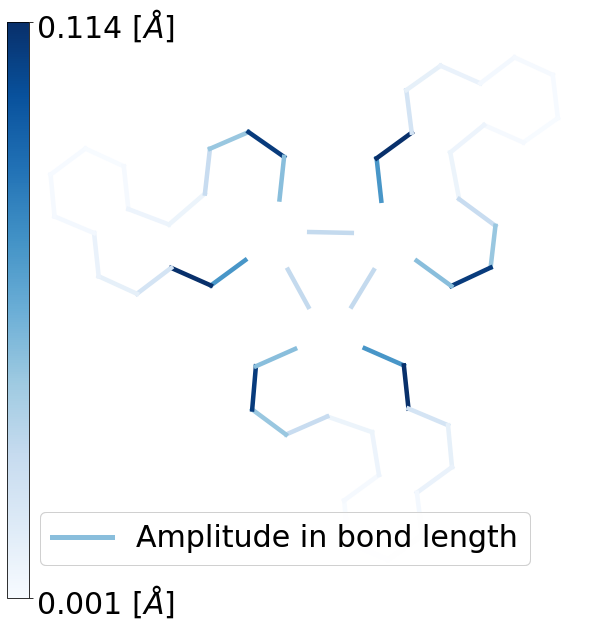

In [21]:
bond_variety(dist_H_periphery_F, hex_periphery, C60 ,title='../../Illustrations/bond_variety.pdf')

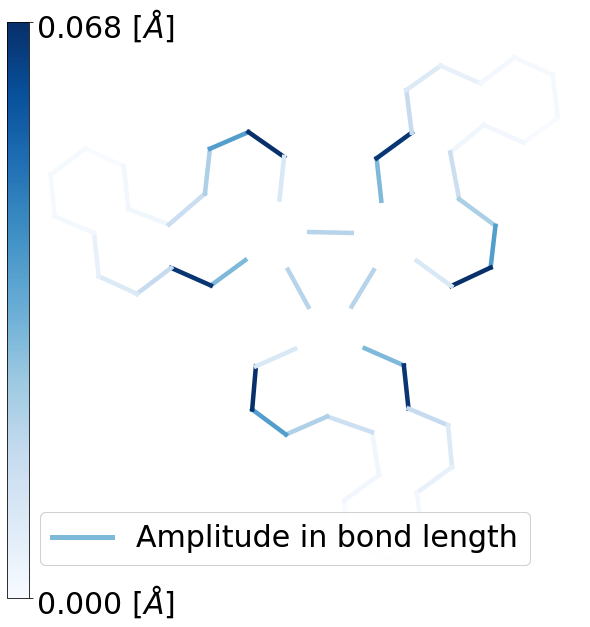

In [22]:
bond_variety(dist_H_periphery_Cl, hex_periphery, C60 ,title='../../Illustrations/bond_variety_Cl.pdf')

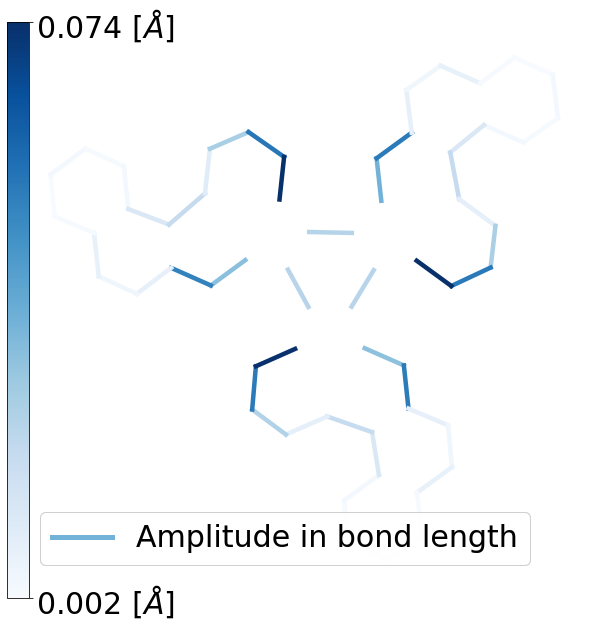

In [23]:
bond_variety(dist_H_periphery_F_inside, hex_periphery, C60 ,title='../../Illustrations/bond_variety_inside.pdf')

In [24]:
def get_face_angles(face, geometry):
    angles = np.zeros(len(face))
    for i,abc in enumerate(zip(face, np.roll(face,-1), np.roll(face,1))):
        a,b,c = abc[0], abc[1], abc[2]
        left = geometry[b] - geometry[a]
        left = left / np.linalg.norm(left)
        right = geometry[c] - geometry[a]
        right = right / np.linalg.norm(right)
        angles[i] = np.rad2deg(np.arccos(left@right))
    return angles

In [25]:
def get_all_face_angles(faces, geometries):
    pent, hexa = 0, 0
    for face in faces:
        if len(face) == 5:
            pent += 1
        else:
            hexa += 1
    angles = [np.zeros([len(geometries),pent,5]), np.zeros([len(geometries),hexa,6])]
    
    for i in range(len(geometries)):
        geometry = geometries[i,-1]
        for face in faces:
            angles[len(face) - 5][i] = get_face_angles(face, geometry)
    return angles

In [26]:
def angle_variety(geometry, graph, title):
    [pent_angles, hex_angles] = get_all_face_angles(graph.graph_unfolding_faces, geometry)
    p_a = pent_angles.reshape([pent_angles.shape[0],pent_angles.shape[-2]*pent_angles.shape[-1]])
    h_a = hex_angles.reshape([hex_angles.shape[0],hex_angles.shape[-2]*hex_angles.shape[-1]])
    angles_tot = np.concatenate([p_a,h_a],axis=1)
    
    angles_id = [np.zeros([pent_angles.shape[1],pent_angles.shape[2],3],dtype=int),np.zeros([hex_angles.shape[1],hex_angles.shape[2],3],dtype=int)]
    id_ph = [0, 0]
    for face in graph.graph_unfolding_faces:
        for i, abc in enumerate(zip(face, np.roll(face,-1), np.roll(face,1))):
            angles_id[len(face) - 5][id_ph[len(face) - 5]][i] = abc
        id_ph[len(face) - 5] += 1
    angles_id_p = angles_id[0].reshape([angles_id[0].shape[0]*angles_id[0].shape[1],3])
    angles_id_h = angles_id[1].reshape([angles_id[1].shape[0]*angles_id[1].shape[1],3])
    angles_id_tot = np.concatenate([angles_id_p,angles_id_h],axis=0)
    
    
    variety = np.argsort(np.abs(np.max(angles_tot,axis=0) - np.min(angles_tot,axis=0)))
    val = np.abs(np.max(angles_tot,axis=0) - np.min(angles_tot,axis=0))

    col = np.arange(1, angles_tot.shape[1] + 1)
    norm = mpl.colors.Normalize(vmin=val.min(), vmax=val.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)                    
    cmap.set_array([])


    fig, ax = plt.subplots(figsize=(10,10))

    for i in range(graph.n_carbon):
            for j in graph.graph_unfolding[i]:
                if j > graph.n_carbon:
                    continue
                tmp = np.stack([graph.vertex_coords[i,:-1],graph.vertex_coords[j,:-1]]).T
                ax.plot(tmp[0],tmp[1],'k-',lw=0.5)

    ax.axis('equal');
    ax.axis('off');

    for j in range(angles_tot.shape[1]):
            color = cmap.to_rgba(val[j])
            id_i = angles_id_tot[j]
            a, b, c = graph.vertex_coords[id_i[0]], graph.vertex_coords[id_i[1]], graph.vertex_coords[id_i[2]]
            angle_plot  =  get_angle_plot(a,b,c,offset=0.8, lw= 4, color=color)
            ax.add_patch(angle_plot)

    cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
    cbar = fig.colorbar(cmap, ticks=[val.max(), val.min()], cax = cbaxes)
    cbar.ax.set_yticklabels(["%.3f [$^\circ$]" %val.max(), "%.3f [$^\circ$]" %val.min()],fontsize=30);

    legend_elements = [plt.Line2D([0], [0], color=cmap.to_rgba(val[variety[-10]]), lw=5, label='Amplitude in bond angle')]
    legend = ax.legend(handles=legend_elements,fontsize=30, loc='lower left')
    ax.add_artist(legend)
    #fig.savefig(title)
    return pent_angles, hex_angles

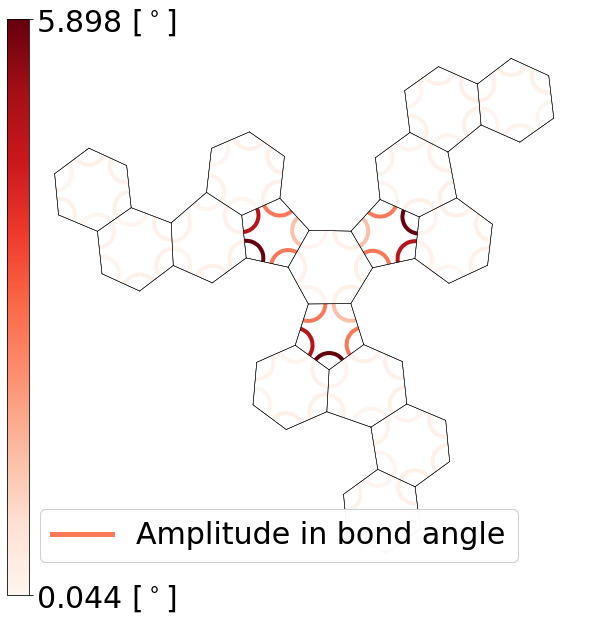

In [27]:
pent_angles_F, hex_angles_F = angle_variety(geometries_F, C60, title = '../../Illustrations/angle_variety.pdf')

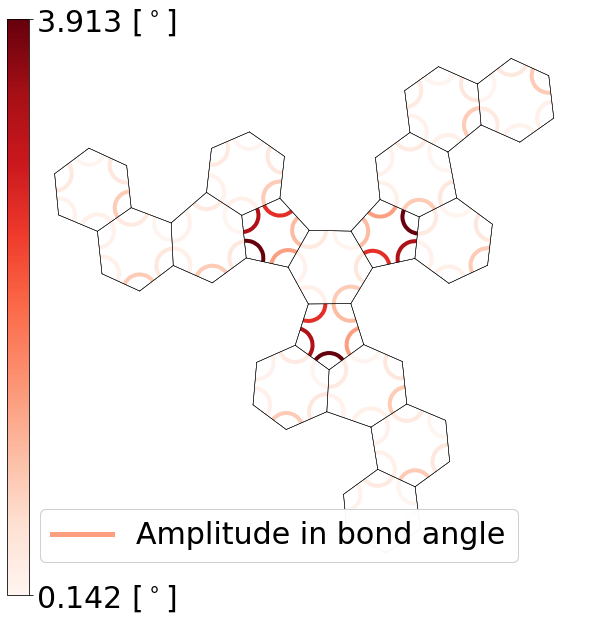

In [28]:
pent_angles_Cl, hex_angles_Cl = angle_variety(geometries_Cl, C60, title = '../../Illustrations/angle_variety_Cl.pdf')

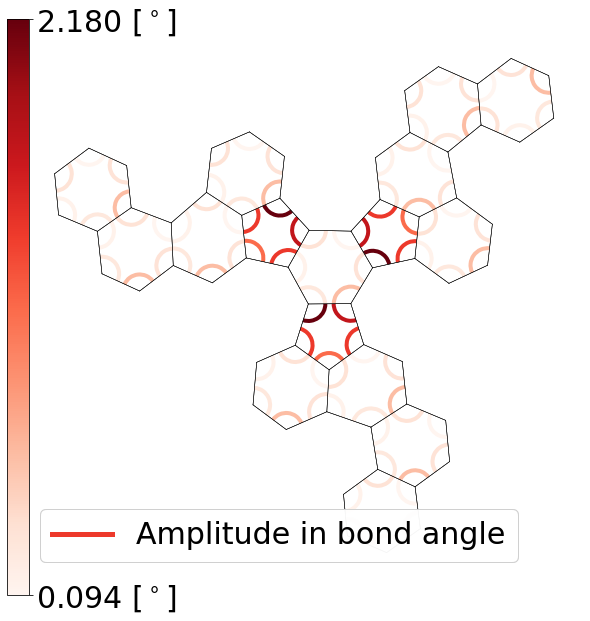

In [29]:
pent_angles_F_inside, hex_angles_F_inside = angle_variety(geometries_F_inside, C60, title = '../../Illustrations/angle_variety_inside.pdf')

In [30]:
def bond_angles(d_CC, pent_angles, hex_angles, title):
    fig, ax = plt.subplots(1,2,figsize=(28,10), sharex=True, sharey=True)
    ax[0].plot(d_CC, pent_angles.reshape(-1,pent_angles.shape[1]*pent_angles.shape[2]), marker='x', linestyle='dashed', color="b");
    ax[1].plot(d_CC, hex_angles.reshape(-1,hex_angles.shape[1]*hex_angles.shape[2]), marker='x', linestyle='dashed',color="r");

    legend_elements = [plt.Line2D([0], [0], color="b", lw=3, marker='x', label='Pentagon angle', linestyle='dashed'),
                       plt.Line2D([0], [0], color="r", lw=3, marker='x',label='Hexagon angle', linestyle='dashed')]

    legend = fig.legend(handles=legend_elements,fontsize=30, loc=(0.2,.6))
    fig.add_artist(legend)


    fig.text(0.05, 0.5, 'Bond angle [$^\circ$]',fontweight='bold',  ha='center', va='center', rotation='vertical', fontsize=30)
    fig.text(0.5, 0.04, '$d_{CC}$ [$\AA$]', fontweight='bold',ha='center', va='center', fontsize=30);
    ax[0].tick_params(labelsize=30)
    ax[1].tick_params(labelsize=30)

    #fig.savefig(title)

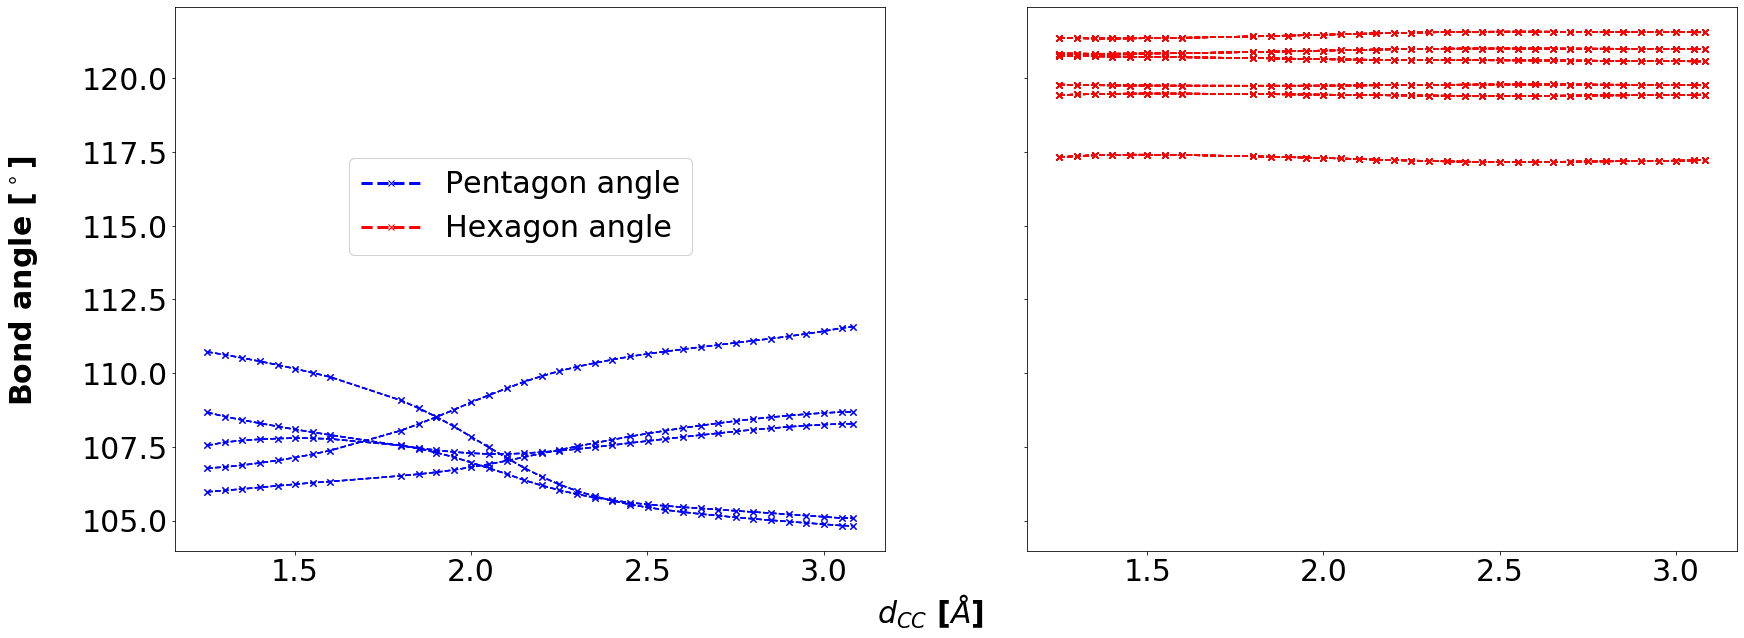

In [31]:
bond_angles(d_CC_F, pent_angles_F, hex_angles_F, title='../../Illustrations/bond_angles.pdf')

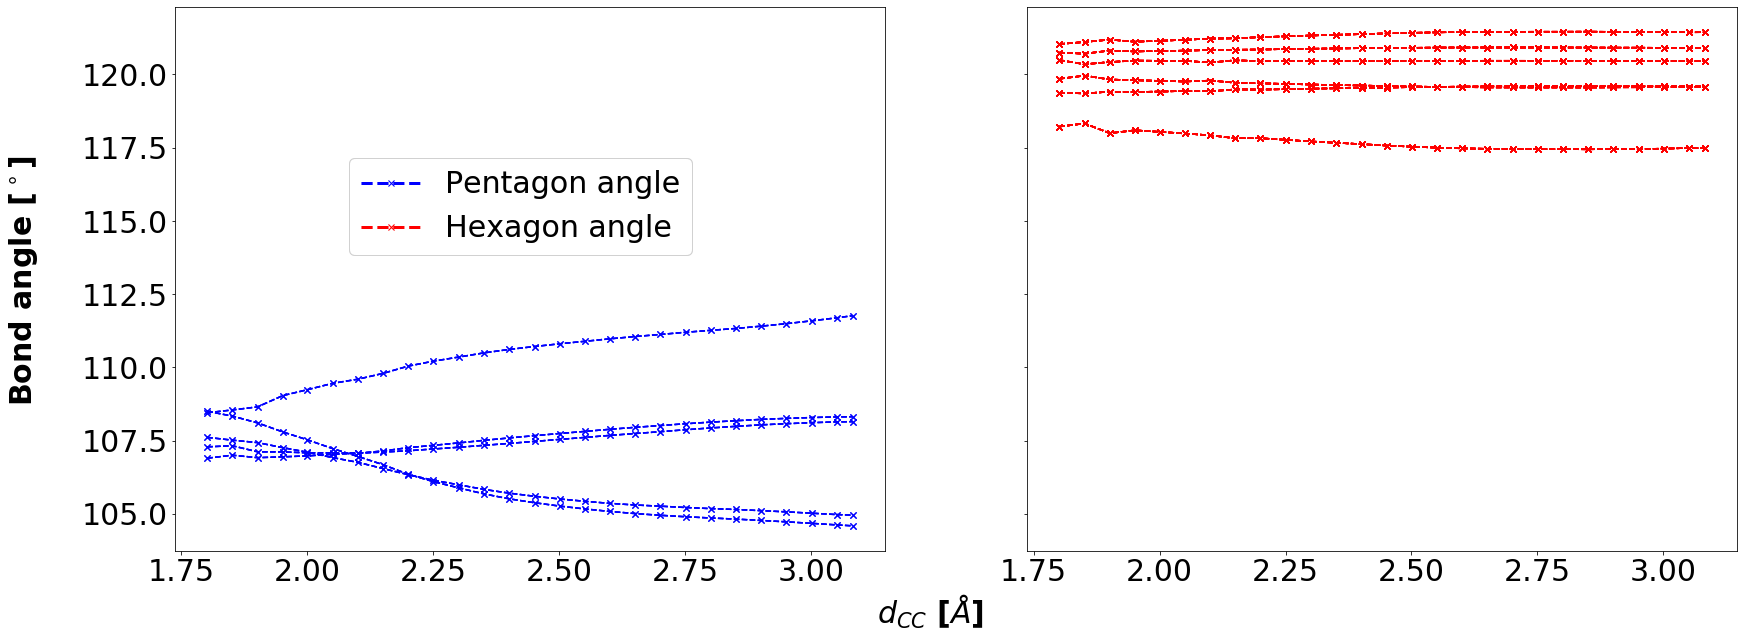

In [32]:
bond_angles(d_CC_Cl, pent_angles_Cl, hex_angles_Cl, title='../../Illustrations/bond_angle_Cl.pdf')

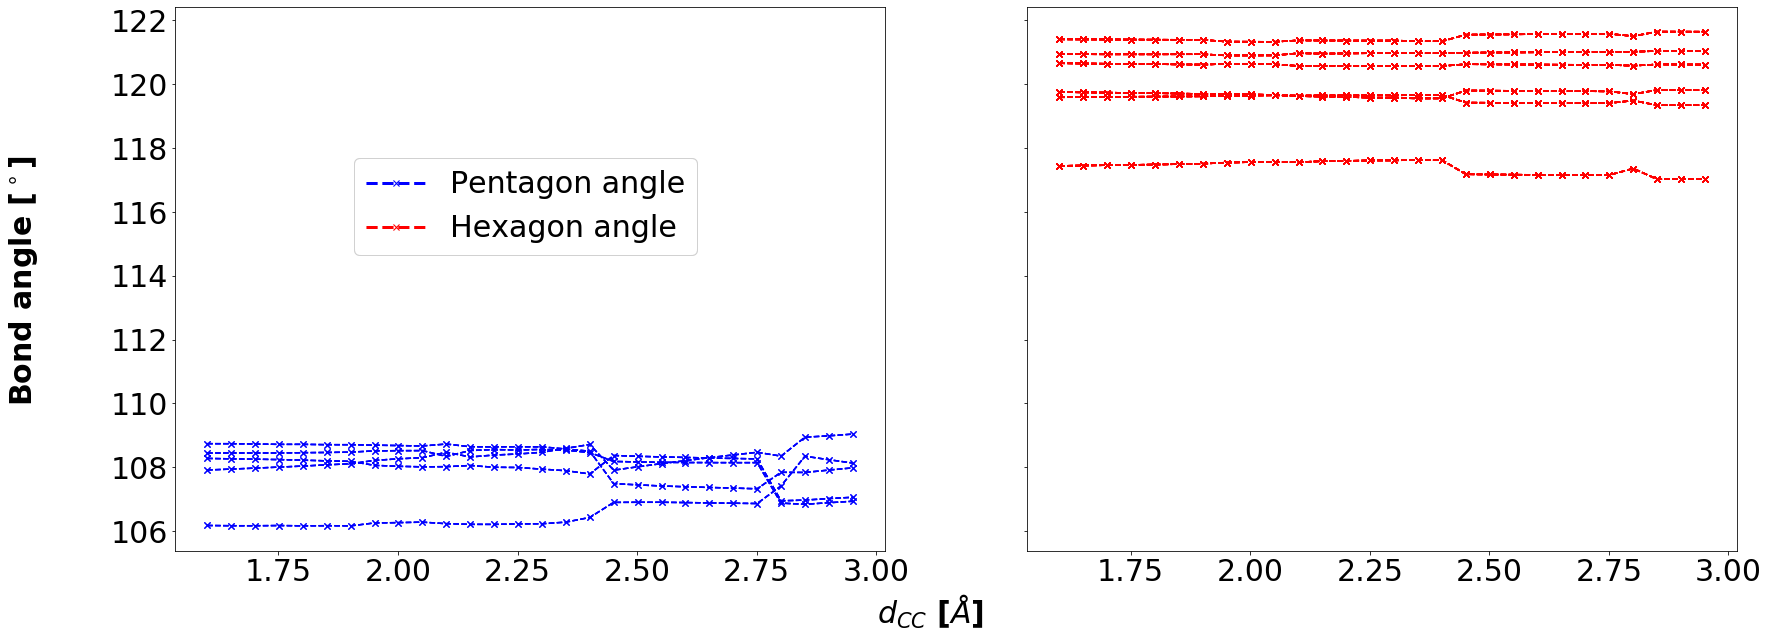

In [33]:
bond_angles(d_CC_F_inside, pent_angles_F_inside, hex_angles_F_inside, title='../../Illustrations/bond_angles_inside.pdf')

In [34]:
def fit_plane(points):
    N = len(points)
    CM = (np.sum(points,axis=0)/N)
    M = points - CM[NA,:]
    U, S, V = np.linalg.svd(M)
    n = V[np.argmin(S)]
    ev = np.min(S)
    err = np.mean(np.abs((M@n)))
    return n, err, ev

In [35]:
def fit_all_planes(geometries, graph):
    errors, evals = np.zeros([len(geometries),len(graph.graph_unfolding_faces)]), np.zeros([len(geometries),len(graph.graph_unfolding_faces)])
    for i in range(len(geometries)):
        geometry = geometries[i,-1]
        for j, face in enumerate(graph.graph_unfolding_faces):
            points = geometry[face]
            _, err, ev = fit_plane(points)
            errors[i,j], evals[i,j] = err, ev
    return errors, evals

In [36]:
def planarity(d_CC, geometries, graph, title,figsize=(15,7)):
    errors, evals = fit_all_planes(geometries, graph)
    
    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.set_ylabel('$\overline{d_\perp}$ [$\AA$]',fontsize = 25 ,fontweight='bold')
    ax1.set_xlabel('Carbon carbon distance [$\AA$]',fontsize = 25, fontweight='bold')

    ax1.plot(d_CC, errors, marker='o',linestyle='dashed', label="Mean absolute distance to plane", color="k");

    ax1.tick_params(labelsize=20)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


    ax2.set_ylabel('EV', color='b',fontsize = 25, fontweight='bold')
    ax2.plot(d_CC, evals, marker='x', linestyle='dashed', label="Correspoding eigenvalues to mean plane solution", color= 'b');
    ax2.tick_params(labelsize=20,labelcolor='b')


    legend_elements = [plt.Line2D([0], [0], color="k", marker='o', lw=1,label="Mean absolute distance to plane", linestyle='dashed')]
    legend_elements1 = [plt.Line2D([0], [0], marker='x', color='b',lw=0, label="Eigenvalues to least-squares plane",markersize=7 ,linestyle='dashed')]  

    fig.text(0.4,0.9, "Mean absolute distance to plane", fontsize=30)
    fig.text(0.4,0.8, "Eigenvalues to mean plane solution", fontsize=30, color="b")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #fig.savefig(title)

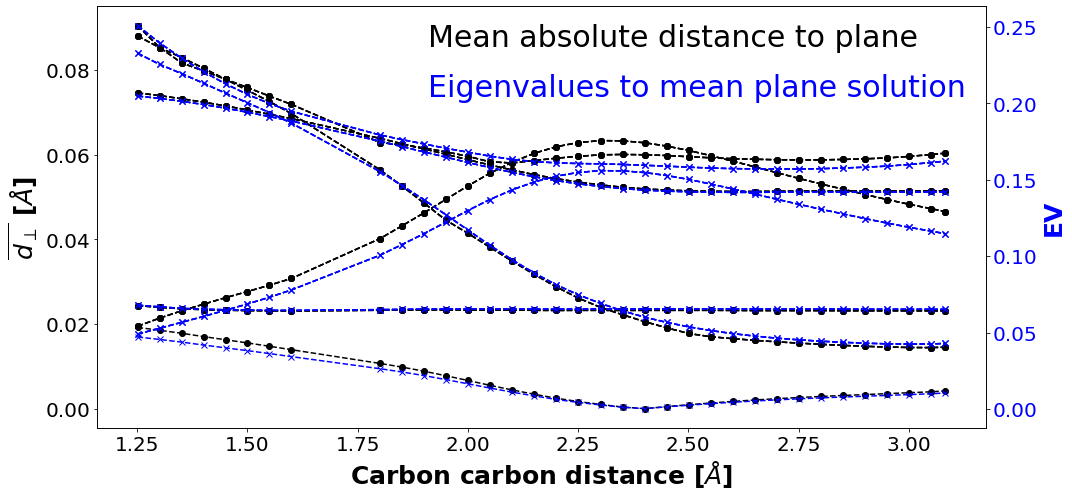

In [37]:
planarity(d_CC_F, geometries_F, C60, title ="../../Illustrations/planarity.pdf")

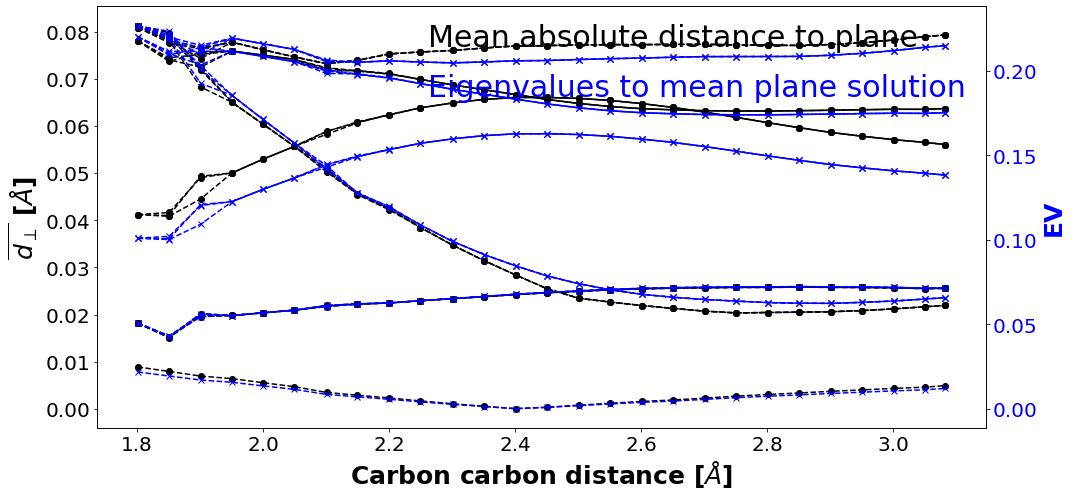

In [38]:
planarity(d_CC_Cl, geometries_Cl, C60, title ="../../Illustrations/planarity_Cl.pdf")

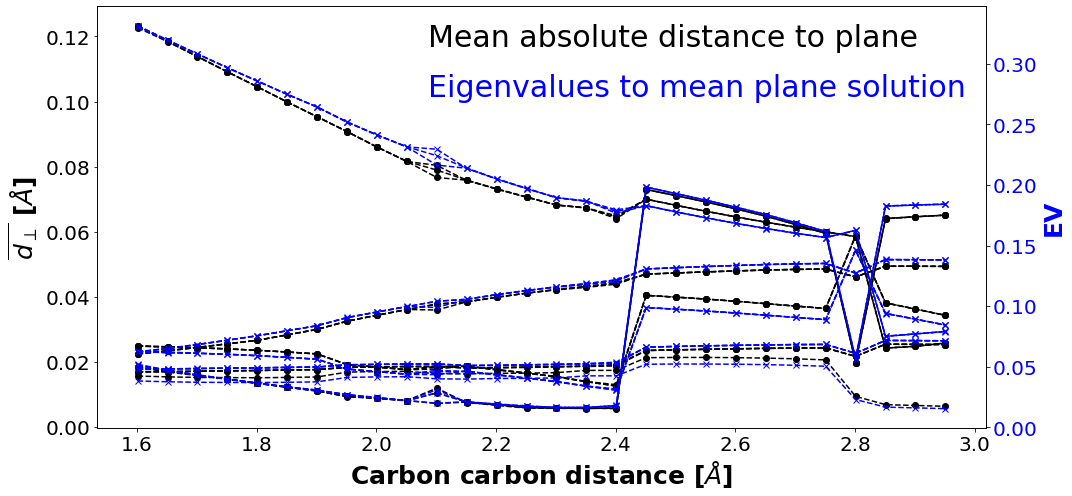

In [39]:
planarity(d_CC_F_inside, geometries_F_inside, C60, title ="../../Illustrations/planarity_inside.pdf")

In [40]:
def plane_variety(geometries, graph, title):
    errors, evals = fit_all_planes(geometries, graph)
    
    variety = np.argsort(np.abs(np.max(errors,axis=0) - np.min(errors,axis=0)))
    val = np.abs(np.max(errors,axis=0) - np.min(errors,axis=0))

    norm = mpl.colors.Normalize(vmin=val.min(), vmax=val.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)                    
    cmap.set_array([])
    

    fig, ax = plt.subplots(figsize=(10,10))

    for i in range(graph.n_carbon):
            for j in graph.graph_unfolding[i]:
                if j > graph.n_carbon:
                    continue
                tmp = np.stack([graph.vertex_coords[i,:-1],graph.vertex_coords[j,:-1]]).T
                ax.plot(tmp[0],tmp[1],'k-',lw=0.5)

    ax.axis('equal');
    ax.axis('off');

    for j in range(evals.shape[1]):
            color = cmap.to_rgba(val[j])
            verts = graph.vertex_coords[graph.graph_unfolding_faces[j]][:,:2]
            ax.fill(verts[:,0], verts[:,1],color=color)
            
    cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
    cbar = fig.colorbar(cmap, ticks=[val.max(), val.min()], cax = cbaxes)
    cbar.ax.set_yticklabels(["%.3f [$\AA$]" %val.max(), "%.3f [$\AA$]" %val.min()],fontsize=30);

    legend_elements = [plt.Line2D([0], [0], color=cmap.to_rgba(val[variety[-10]]), lw=5, label='Amplitude of mean distance to plane')]
    legend = ax.legend(handles=legend_elements,fontsize=27, loc='lower left')
    ax.add_artist(legend)
    #fig.savefig(title)

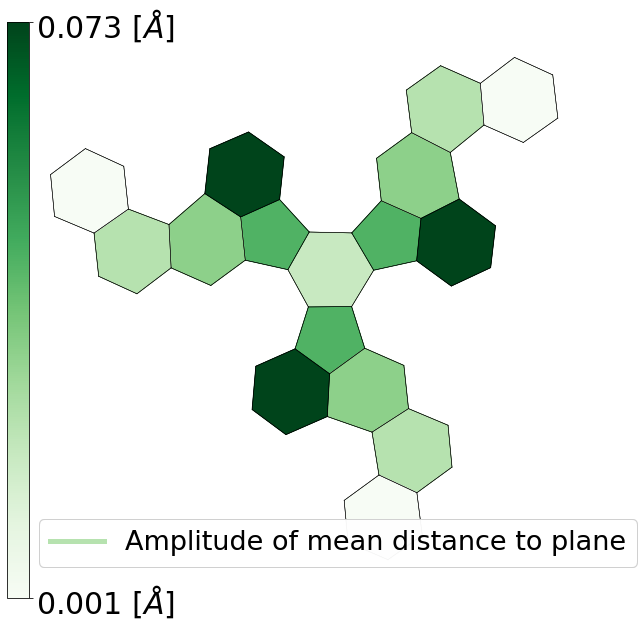

In [41]:
plane_variety(geometries_F, C60, title="../../Illustrations/plane_variety.pdf")

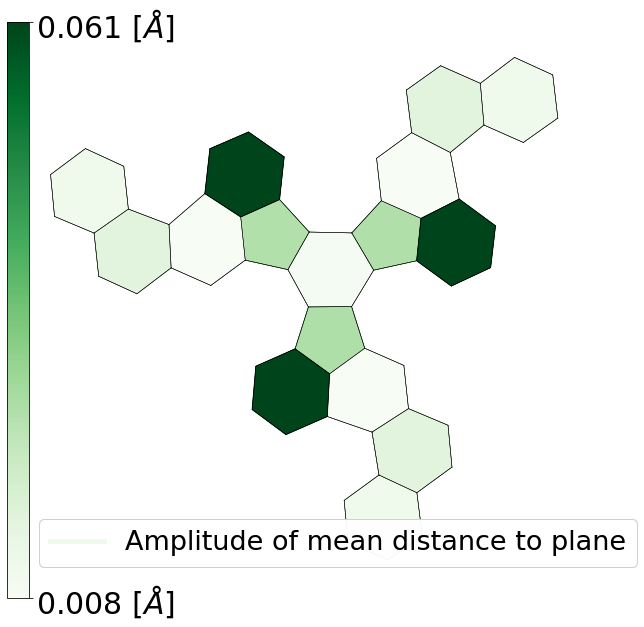

In [42]:
plane_variety(geometries_Cl, C60, title="../../Illustrations/plane_variety_Cl.pdf")

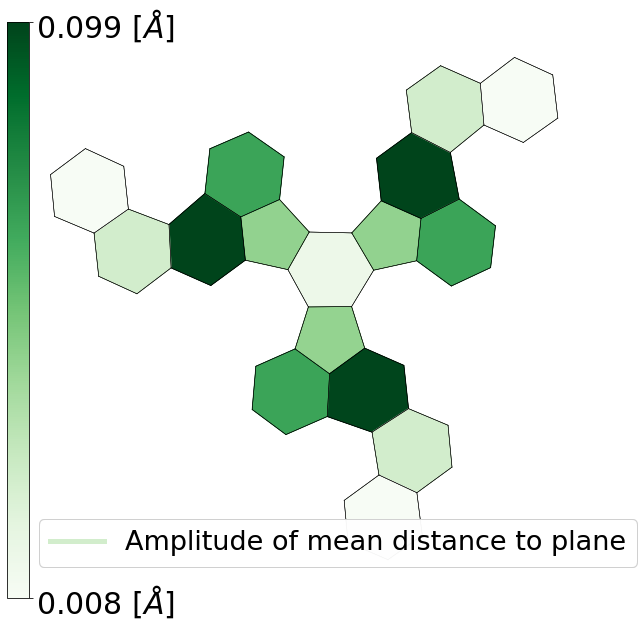

In [43]:
plane_variety(geometries_F_inside, C60, title="../../Illustrations/plane_variety_inside.pdf")